# LD4 - Analysis of Audio Signals

In [357]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from IPython.display import Audio
import soundfile as sf
#import librosa

from IPython.core.display import HTML
HTML(r"""
<style>
    .jp-MarkdownCell .jp-RenderedHTMLCommon {
        font-family: "Times New Roman", Times, serif;
        font-size: 20px
    }
</style>
""")

In [358]:
FRAME_SIZE = 2048   # window size
HOP_LENGTH = 1024
NFFT = 2048

In [359]:
data, fs = sf.read('samples.wav')
x = data[:,0] # stereo to mono
t = np.linspace(0, len(x)/fs, len(x))
Audio(data = x, rate = fs)

## Envelope detection via Leaky integrator

$y(n) = (1-a_1)|x(n)| + a_1 y(n-1)$

In [360]:
def leaky_integrator(signal, alpha):
    integrator_output = np.zeros_like(signal)
    integrator_output[0] = (1-alpha) * abs(signal[0])
    for i in range(1, len(signal)):
        integrator_output[i] = alpha * integrator_output[i - 1] + (1 - alpha) * abs(signal[i])
    return integrator_output

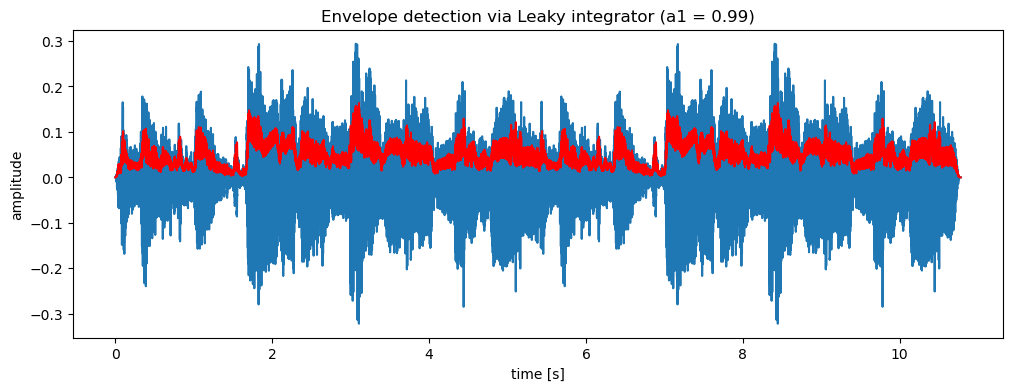

In [361]:
envelope = leaky_integrator(x, 0.99)

plt.figure(figsize=(12, 4))

plt.plot(t, x)
plt.plot(t, envelope, 'r')
plt.xlabel('time [s]')
plt.ylabel('amplitude')
plt.title('Envelope detection via Leaky integrator (a1 = 0.99)')
plt.show()

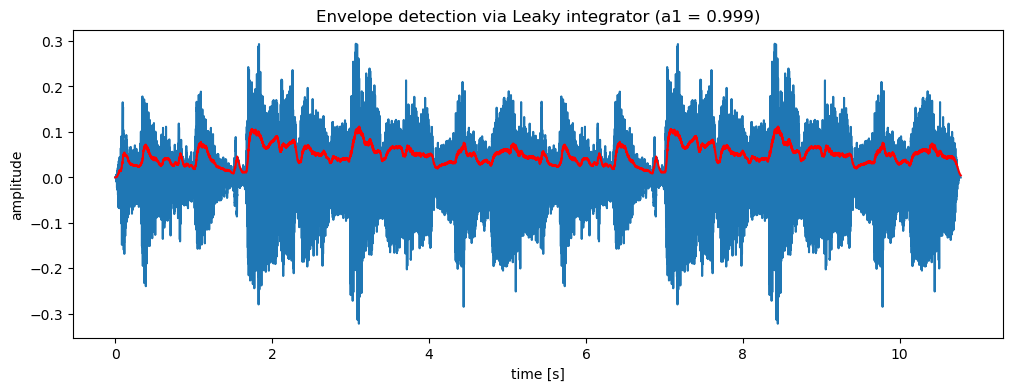

In [362]:
envelope = leaky_integrator(x, 0.999)

plt.figure(figsize=(12, 4))

plt.plot(t, x)
plt.plot(t, envelope, 'r')
plt.xlabel('time [s]')
plt.ylabel('amplitude')
plt.title('Envelope detection via Leaky integrator (a1 = 0.999)')
plt.show()

Is it normal that the envelope(red line) here is not coincide with the real envelope of the signal?

Or is there anything wrong in my code?

## Spectral Centroid

$c = \frac{f_s}{N}\frac{\sum_{k=0}^{N/2}k|X(k)|}{\sum_{k=0}^{N/2}|X(k)|}$

In [363]:
def spectral_centroid(x, fs, n_fft=2048, hop_length=1024):
    # Compute the number of frames
    num_frames = 1 + (len(x) - n_fft) // hop_length
    
    # Initialize an array to store the STFT magnitude spectra
    stft = np.zeros((num_frames, n_fft // 2))
    
    # Apply zero-padding to the end of the signal if necessary
    x_padded = np.pad(x, (0, n_fft - len(x) % n_fft), mode='constant')
    
    # Compute the STFT
    for i in range(num_frames):
        start_idx = i * hop_length
        end_idx = start_idx + n_fft
        frame = x_padded[start_idx:end_idx]
        
        # Apply a windowing function to the frame
        windowed_frame = frame * np.hamming(len(frame))
        
        # Compute the magnitude spectrum of the windowed frame
        frame_fft = np.fft.fft(windowed_frame)
        magnitude_spectrum = np.abs(frame_fft)[:n_fft // 2]
        
        # Normalize the magnitude spectrum by the sum of the window function
        magnitude_spectrum /= np.sum(np.hamming(len(frame)))
        
        stft[i] = magnitude_spectrum
    
    # Calculate the frequencies corresponding to the DFT bins
    freqs = np.fft.fftfreq(n_fft, d=1/fs)[:n_fft//2]
    
    # Compute the spectral centroid
    centroid = np.sum(stft * freqs, axis=1) / np.sum(stft, axis=1)
    
    return centroid

In [364]:
centroid = spectral_centroid(x, fs, n_fft=NFFT, hop_length=HOP_LENGTH)

In [365]:
#sc = librosa.feature.spectral_centroid(y = x, sr = fs, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

In [366]:
t = np.arange(len(centroid)) * HOP_LENGTH / fs
#t_ = np.arange(len(sc)) * HOP_LENGTH / fs

Text(0.5, 1.0, 'Spectral Centroid')

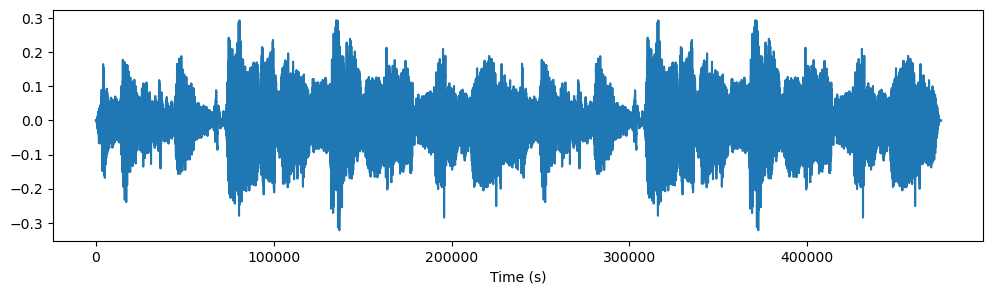

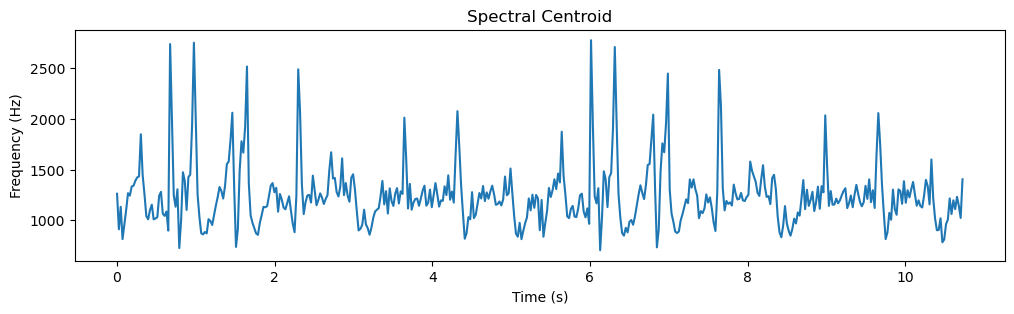

In [367]:
plt.figure(figsize=(12, 3))
plt.plot(x)
plt.xlabel('Time (s)')

plt.figure(figsize=(12, 3))
plt.plot(t, centroid)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectral Centroid')

# plt.figure(figsize=(12, 3))
# plt.plot(t_, sc)
# plt.xlabel('Time (s)')
# plt.ylabel('Frequency (Hz)')
# plt.title('Spectral Centroid (librosa)')

## Simple pitch detection

### Autocorrelation Method

In [368]:
# generate a scale
fs = 44100  # Sampling frequency (Hz)
duration = 1.0  # Duration of each note (seconds)

# Define the frequencies for the C major scale notes
c_major_scale_frequencies = {
    'C4': 261.63,
    'D4': 293.66,
    'E4': 329.63,
    'F4': 349.23,
    'G4': 392.00,
    'A4': 440.00,
    'B4': 493.88,
    'C5': 523.25
}

# Generate the audio samples for each note in the C major scale
scale = np.concatenate([
    0.5 * np.sin(2 * np.pi * f * np.linspace(0, duration, int(fs * duration), endpoint=False))
    for f in c_major_scale_frequencies.values()
])

# Normalize the audio to ensure it is within the range [-1, 1]
scale /= np.max(np.abs(scale))
Audio(data = scale, rate = fs)

In [369]:
window_types = ('rect','hann','cosine','hamming')

def windowing(data, frame_length, hop_size, windowing_function):
    data = np.array(data)
    number_of_frames = 1 + int(np.floor((data.shape[0] - frame_length)/hop_size)) #259
    
    frame_matrix = np.zeros((frame_length,number_of_frames))

    if windowing_function == 'rect':
        window = np.ones(frame_length) 
    elif windowing_function == 'hann':
        window = np.hanning(frame_length) 
    elif windowing_function == 'cosine':
        n = np.arange(frame_length)
        window = np.sin(np.pi * n / (frame_length - 1)) ** 2 
    elif windowing_function == 'hamming':
        window = np.hamming(frame_length) 
    else:
        os.error('Windowing function not supported')
        
    ## Copy each frame segment from data to the corresponding column of frame_matrix.
    ## If the end sample of the frame segment is larger than data length,
    ## zero-pad the remainder to achieve constant frame length.
    ## Remember to apply the chosen windowing function to the frame!
    
    for i in range(number_of_frames):
        frame = np.zeros(frame_length) # Initialize frame as zeroes
   
        datawin_begin_index = hop_size * i
        datawin_end_index = datawin_begin_index + frame_length
        
        if datawin_end_index <= len(data):
            frame = data[datawin_begin_index:datawin_end_index]
        else:
            frame[:len(data) - datawin_begin_index] = data[datawin_begin_index:]
        
        frame = frame/np.max(np.abs(frame)) # normalize
        
        frame *= window  # Apply the chosen windowing function
        
        frame_matrix[:,i] = frame   # Copy frame to frame_matrix
    return frame_matrix

### comparison using different window

In [370]:
frame_matrix_rec = windowing(scale, FRAME_SIZE, HOP_LENGTH, window_types[0]) 
frame_matrix_hann = windowing(scale, FRAME_SIZE, HOP_LENGTH, window_types[1]) 
frame_matrix_cos = windowing(scale, FRAME_SIZE, HOP_LENGTH, window_types[2]) 
frame_matrix_ham = windowing(scale, FRAME_SIZE, HOP_LENGTH, window_types[3]) 


In [371]:
def pitch_detection(frame_matrix, fs):
    pitchs = []
    for i in range(frame_matrix.shape[1]):   #343
        data_window = frame_matrix[:,i]
        acr = np.correlate(data_window, data_window, mode='full')
        acr = acr[len(acr)//2:]
        peaks, _ = signal.find_peaks(acr)
        pitch = fs / peaks[0]
        pitchs.append(pitch)
    return pitchs

In [372]:
pitch_rec = pitch_detection(frame_matrix_rec, fs)
pitch_hann = pitch_detection(frame_matrix_hann, fs)
pitch_cos = pitch_detection(frame_matrix_cos, fs)
pitch_ham = pitch_detection(frame_matrix_ham, fs)


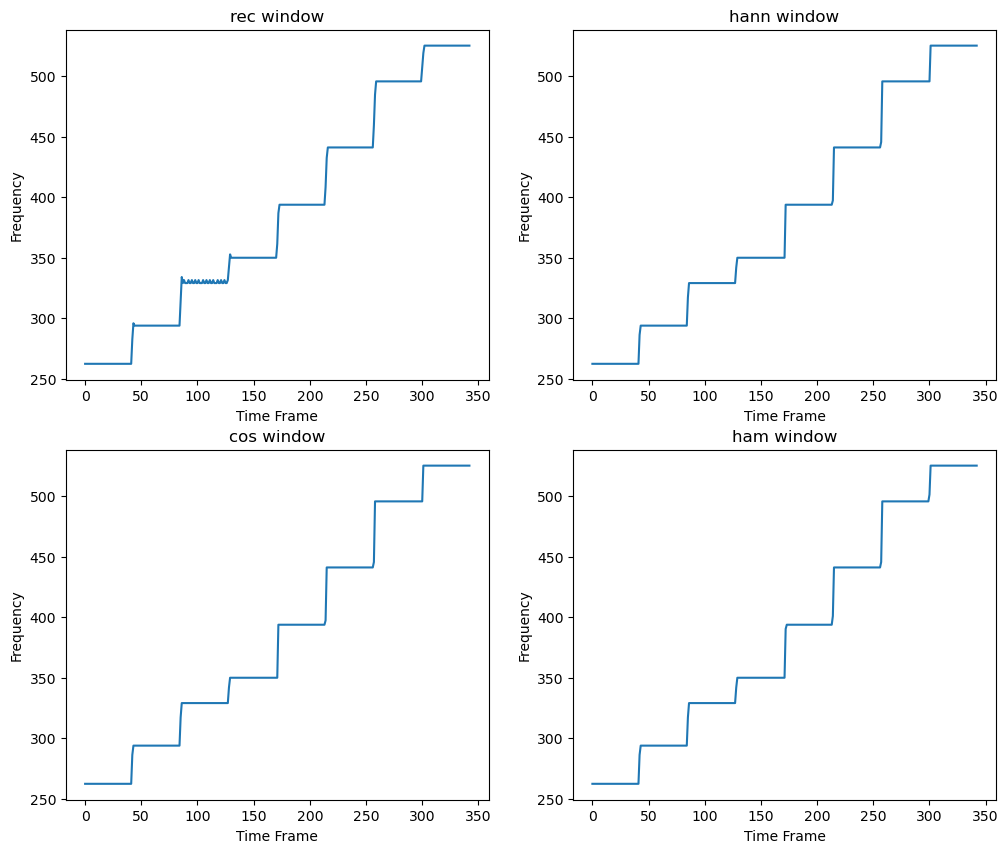

In [373]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(pitch_rec)
plt.xlabel('Time Frame')
plt.ylabel('Frequency')
plt.title('rec window')

plt.subplot(2, 2, 2)
plt.plot(pitch_hann)
plt.xlabel('Time Frame')
plt.ylabel('Frequency')
plt.title('hann window')

plt.subplot(2, 2, 3)
plt.plot(pitch_cos)
plt.xlabel('Time Frame')
plt.ylabel('Frequency')
plt.title('cos window')

plt.subplot(2, 2, 4)
plt.plot(pitch_ham)
plt.xlabel('Time Frame')
plt.ylabel('Frequency')
plt.title('ham window')

plt.show()

From these four plots, we can see that compared to the rectangular window, there is less burr in the pitch plot when using the Hann, cosine, and Hamming windows, at least in this task where the audio is a simple scale.